In [1]:
# run the script initnotebook.py in the cuurent folder
# Error when run multiple times becasue the directory changed
%run initnotebook.py

current working dir/home/abjawad/Documents/GitHub/local-attention-model


In [2]:
import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from config_cityscapes import *
import os
from dataloader.cityscapes_dataloader import CityscapesDataset
from val_segformer_rgbonly import val_cityscape

import torch.nn.functional as F
from utils.visualize import unnormalize_img_numpy
import matplotlib.pyplot as plt

In [3]:
from visualizer.visualizer import *

In [4]:
config_path = 'dataloader/cityscapes_rgbd_config.yaml'
config_path = os.path.join(projectFolder, config_path)

cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [5]:
cityscapes_test = CityscapesDataset(cfg, split='train')
test_loader = DataLoader(cityscapes_test, batch_size=1, shuffle=False, num_workers=4) # batchsize?
print(f'total test sample: {len(cityscapes_test)} v_iteration:{len(test_loader)}')


Using RGB input
Using RGB input
Found 2975 train images
total test sample: 2975 v_iteration:2975


In [6]:
def find_index_of_image(test_loader, image_name):
    files = test_loader.dataset.files
    for idx, path in enumerate(files['train']):
        if image_name in path:
            return idx
    return -1

image_name = 'cologne_000008_000019_leftImg8bit.png'
index = find_index_of_image(test_loader, image_name)
print(index)

216


In [7]:
pretrained_model_path = './pretrained/model_400.pth'
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)

model = segmodel(cfg=config, criterion=criterion, norm_layer=nn.BatchNorm2d, test=True)
model = nn.DataParallel(model, device_ids = config.device_ids)
# model.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

17 19:29:47 Using backbone: Segformer-B2
17 19:29:47 Using MLP Decoder


In [8]:
saved_model_path = os.path.join(projectFolder, pretrained_model_path)
print(saved_model_path)
# exit()
state_dict = torch.load(saved_model_path)
model.load_state_dict(state_dict['model'], strict=False)
print(f'model loaded')
epoch = state_dict['epoch']


/home/abjawad/Documents/GitHub/local-attention-model/./pretrained/model_400.pth
model loaded


In [9]:
# val_loss, val_mean_iou = val_cityscape(epoch, test_loader, model)

In [25]:
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        if idx != index:
            continue
        imgs = sample['image']      #B, 3, 1024, 2048
        gts = sample['label']       #B, 1024, 2048
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

        img = imgs[:, :, :, 1024:]
        gt = gts[:, :, :1024]
        loss, out, atten = model(img, gt, visualize=True, attention=True)
        print('loss = ', loss.shape)
        print('out = ', out.shape)
        print('atten = ', len(atten))
        print(img.shape, gt.shape)
        # print(len(out), out[0].shape, out[1].shape)
        break

# tokenization:  torch.Size([1, 65536, 64])
# tokenization:  torch.Size([1, 16384, 128])
# tokenization:  torch.Size([1, 4096, 320])
# tokenization:  torch.Size([1, 1024, 512])

input:  torch.Size([1, 3, 1024, 1024])
tokenization:  torch.Size([1, 65536, 64])
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_1/63.jpg shape:(256, 256)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_2/127.jpg shape:(128, 128)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_3/319.jpg shape:(64, 64)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_4/511.jpg shape:(32, 32)
loss =  torch.Size([])
out =  torch.Size([1, 19, 1024, 1024])
atten =  4
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])


In [27]:
print(img.shape)
print(len(atten))

torch.Size([1, 3, 1024, 1024])
4


In [28]:
import matplotlib.pyplot as plt


def get_attention_matrix(attention, layer, head):
    # sanity check
    layer = layer - 1
    head = head - 1
    if layer > len(attention):
        print('layer index out of range')
        return None
    if head > len(attention[layer]):
        print('head index out of range')
        return None
    atten = attention[layer][head]
    atten = atten.cpu().numpy()
    return atten

def plot_attention(img, pixel, attention, layer, head, target_size, alpha):
    factor = 4
    layer_factor = 2 ** (layer - 1)
    downsample_factor = factor * layer_factor

    patch_size = int(np.sqrt(attention.shape[1]))
    unnormalized_image = unnormalize_img_numpy(img)
    rescaled_image_layer = cv2.resize(unnormalized_image, target_size)
    attention_map_layer = np.zeros(target_size)

    downsized_pixel = (pixel[0] // downsample_factor, pixel[1] // downsample_factor)
    downsized_image = unnormalized_image[::downsample_factor, ::downsample_factor]

    array_shape = downsized_image.shape
    patch_idx = (pixel[1] // downsample_factor // patch_size) * (array_shape[1] // patch_size) + (pixel[0] // downsample_factor // patch_size)

    pixel_inside_patch = (((pixel[0] // downsample_factor) % patch_size), ((pixel[1] // downsample_factor) % patch_size))
    pixel_idx_inside_patch = pixel_inside_patch[1] * patch_size + pixel_inside_patch[0]
    attention_patch = attention[patch_idx]
    attention_pixel = attention_patch[pixel_idx_inside_patch].reshape(patch_size, patch_size)

    upscaled_attention_pixel = cv2.resize(attention_pixel, (layer_factor * patch_size, layer_factor * patch_size))
    patch_start = (patch_idx // int(np.sqrt(attention.shape[0])) * patch_size * layer_factor, patch_idx % int(np.sqrt(attention.shape[0])) * patch_size * layer_factor)
    attention_map_layer[patch_start[0]:patch_start[0] + upscaled_attention_pixel.shape[0], patch_start[1]:patch_start[1] + upscaled_attention_pixel.shape[1]] = upscaled_attention_pixel

    plt.imshow(rescaled_image_layer)
    plt.imshow(attention_map_layer, alpha=alpha, cmap='viridis')
    plt.show()


for i in range(1, len(atten)+1):
    for j in range(1, len(atten[i-1])+1):
        shape = get_attention_matrix(atten, i, j).shape
        if len(shape) == 4:
            atten[i-1][j-1] = atten[i-1][j-1].reshape(shape[1], shape[2], shape[3])
        print('attention layer', i, 'head ', j, atten[i-1][j-1].shape)


attention layer 1 head  1 torch.Size([256, 256, 256])
attention layer 1 head  2 torch.Size([1024, 64, 64])
attention layer 2 head  1 torch.Size([64, 256, 256])
attention layer 2 head  2 torch.Size([256, 64, 64])
attention layer 2 head  3 torch.Size([256, 64, 64])
attention layer 2 head  4 torch.Size([1024, 16, 16])
attention layer 3 head  1 torch.Size([256, 16, 16])
attention layer 3 head  2 torch.Size([256, 16, 16])
attention layer 3 head  3 torch.Size([1024, 4, 4])
attention layer 3 head  4 torch.Size([1024, 4, 4])
attention layer 3 head  5 torch.Size([1, 4096, 4096])
attention layer 4 head  1 torch.Size([256, 4, 4])
attention layer 4 head  2 torch.Size([256, 4, 4])
attention layer 4 head  3 torch.Size([256, 4, 4])
attention layer 4 head  4 torch.Size([256, 4, 4])
attention layer 4 head  5 torch.Size([1, 1024, 1024])
attention layer 4 head  6 torch.Size([1, 1024, 1024])
attention layer 4 head  7 torch.Size([1, 1024, 1024])
attention layer 4 head  8 torch.Size([1, 1024, 1024])


In [62]:
pixel = (300, 410)
layer = 2
head = 3

attention = get_attention_matrix(atten, layer, head)

factor = 4
layer_factor = 2**(layer - 1)
downsample_factor = factor * layer_factor

target_size = (256, 256)
patch_size = np.sqrt(attention.shape[1]).astype(int)

print('patch_size', patch_size)
print('downsample_factor', downsample_factor)
print("attention shape ", attention.shape, " attention arr type ", type(attention))


patch_size 8
downsample_factor 8
attention shape  (256, 64, 64)  attention arr type  <class 'numpy.ndarray'>


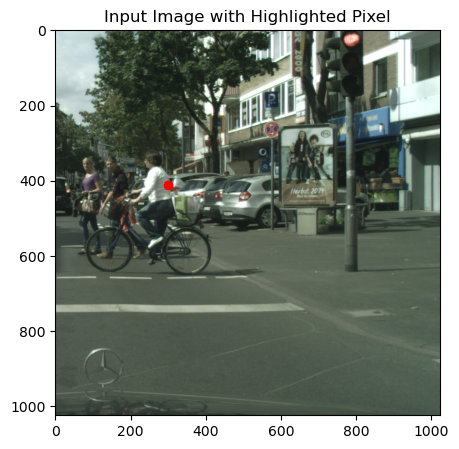

In [63]:
# Convert the tensor to a NumPy array
# image_array = image[0].permute(1, 2, 0).cpu().numpy()
unnormalized_image = unnormalize_img_numpy(img)
image_array = unnormalized_image

plt.figure(figsize=(5, 5))
plt.imshow(image_array)

# Highlight the pixel at (100, 100) in red
plt.scatter(pixel[0], pixel[1], c='red', marker='o')

plt.title('Input Image with Highlighted Pixel')
plt.show()

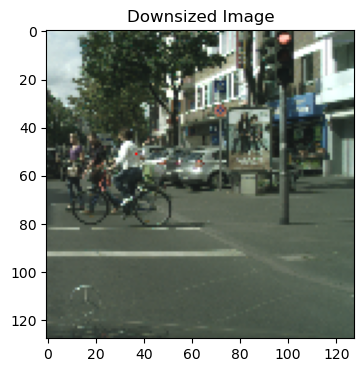

In [64]:
downsized_pixel = (pixel[0] // downsample_factor, pixel[1] // downsample_factor)

# downsize numpy image by downsample factor
downsized_array = unnormalized_image[::downsample_factor, ::downsample_factor]

# making image red at the pixel location
downsized_array[downsized_pixel[1], downsized_pixel[0]] = [255, 0, 0]

# Plot the downsized image
plt.figure(figsize=(4, 4))
plt.imshow(downsized_array)

plt.title('Downsized Image')
plt.show()

In [65]:
print('attention shape ', attention.shape)
patch_size = np.sqrt(attention.shape[1]).astype(int)
print('patch size ', patch_size)

print("downsized array shape ", downsized_array.shape)

attention shape  (256, 64, 64)
patch size  8
downsized array shape  (128, 128, 3)


In [66]:
import numpy as np

# Define the downsized array
array_shape = downsized_array.shape

# Calculate the number of rows and columns for patches
num_rows = array_shape[0] // patch_size
num_cols = array_shape[1] // patch_size

# Create an empty list to store the patches
patches = []

# Iterate through the array and extract patches
for i in range(num_rows):
    for j in range(num_cols):
        row_start = i * patch_size
        row_end = (i + 1) * patch_size
        col_start = j * patch_size
        col_end = (j + 1) * patch_size
        patch = downsized_array[row_start:row_end, col_start:col_end]
        patches.append(patch)

print("num_rows ", num_rows, " num_cols ", num_cols)
print('Number of patches = ', len(patches))

num_rows  16  num_cols  16
Number of patches =  256


In [67]:
# # Create a single plot for all patches
# fig, axarr = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# for i in range(num_rows):
#     for j in range(num_cols):
#         axarr[i, j].imshow(patches[i * num_cols + j])
#         axarr[i, j].axis('off')

# plt.show()

In [68]:
# find the patch that contains the pixel

# Calculate the row and column of the patch that contains the pixel
patch_row = downsized_pixel[1] // patch_size
patch_col = downsized_pixel[0] // patch_size

print('Patch row, col', patch_row, patch_col)

patch_idx = patch_row * num_cols + patch_col

print('Patch index = ', patch_idx)

pixel_inside_patch = (((pixel[1] // downsample_factor) % patch_size), 
                      ((pixel[0] // downsample_factor) % patch_size))

print('Pixel inside patch = ', pixel_inside_patch)

pixel_idx_inside_patch = pixel_inside_patch[1] * patch_size + pixel_inside_patch[0]

print('Pixel index inside patch = ', pixel_idx_inside_patch)
print(patches[patch_idx][pixel_idx_inside_patch//patch_size, pixel_idx_inside_patch%patch_size])


print(attention.shape)

# Get the attention for the patch that contains the pixel
attention_patch = attention[patch_idx]

print('Attention patch shape = ', attention_patch.shape)

attention_pixel = attention_patch[pixel_idx_inside_patch]

print('Attention for the pixel = ', attention_pixel.shape)

# reshape to 2d with patch_size x patch_size
attention_pixel = attention_pixel.reshape(patch_size, patch_size)

print('Attention for the pixel = ', attention_pixel.shape)

# plot attention_pixel (16, 16) over the patch (16, 16, 3)
patch_with_pixel = patches[patch_idx].copy()


Patch row, col 6 4
Patch index =  100
Pixel inside patch =  (3, 5)
Pixel index inside patch =  43
[126 139 128]
(256, 64, 64)
Attention patch shape =  (64, 64)
Attention for the pixel =  (64,)
Attention for the pixel =  (8, 8)


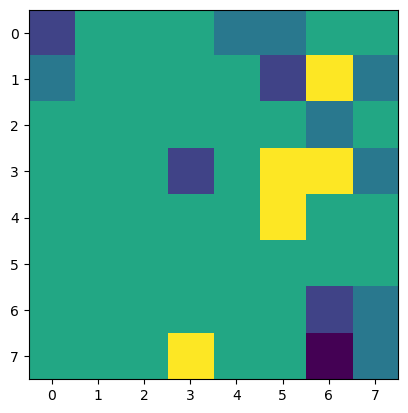

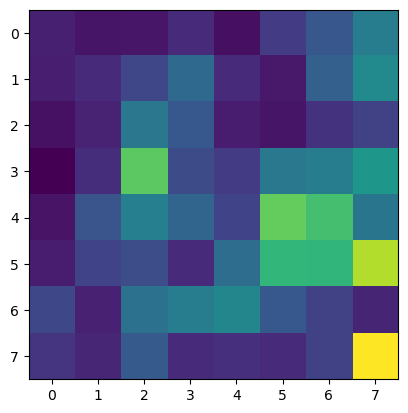

In [78]:
# plot attention_patch
atten_patch = np.mean(attention_patch, axis=1).reshape(patch_size, patch_size)


atten_patch1 = np.mean(attention_patch, axis=0).reshape(patch_size, patch_size)

# plt.imshow(attention_patch)
plt.imshow(atten_patch, alpha=1, cmap='viridis')
plt.show()
plt.imshow(atten_patch1, alpha=1, cmap='viridis')
plt.show()


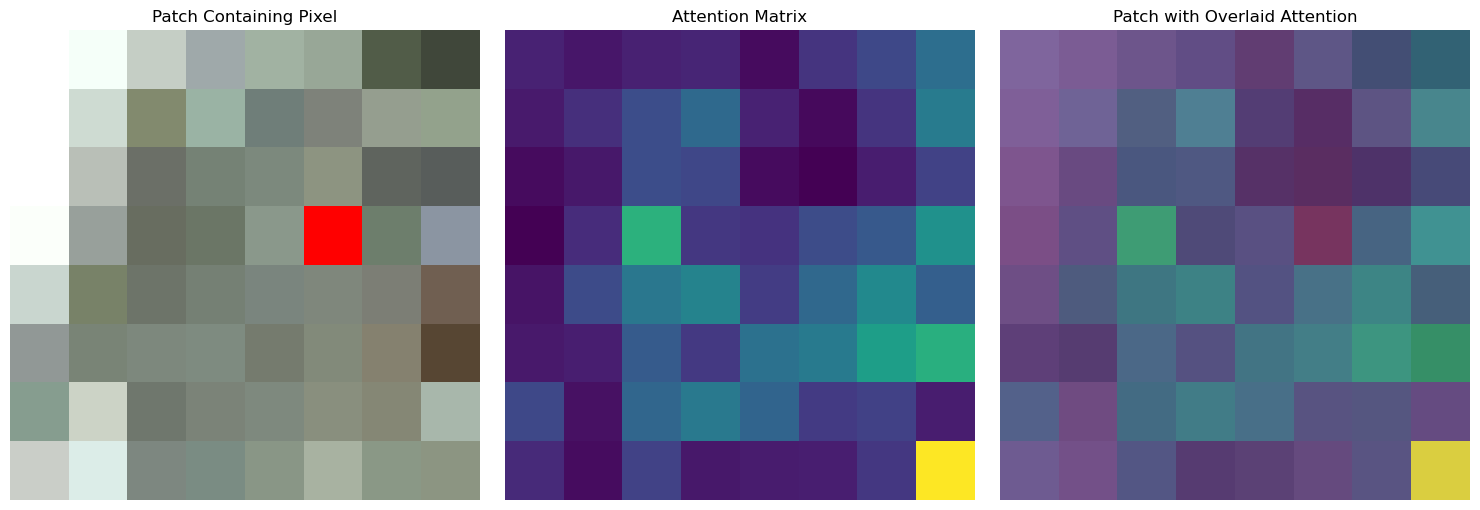

In [69]:

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot the patch that contains the pixel
axes[0].imshow(patches[patch_idx])
axes[0].axis('off')  # Turn off axis
axes[0].set_title('Patch Containing Pixel')

# Plot the attention for the pixel
axes[1].imshow(attention_pixel)
axes[1].axis('off')  # Turn off axis
axes[1].set_title('Attention Matrix')

# Plot the patch with the overlaid attention
patch_with_pixel = patches[patch_idx].copy()
axes[2].imshow(patch_with_pixel)
axes[2].imshow(attention_pixel, alpha=0.7, cmap='viridis')  # Overlay the attention
axes[2].axis('off')  # Turn off axis
axes[2].set_title('Patch with Overlaid Attention')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


rescaled image for plot  (256, 256, 3)
Attention  (256, 64, 64)
attention pixel  (8, 8)
upscaled attention factor  2
upscaled attention pixel  (16, 16)
patch idx  100
patch size  8
patch start  (96, 64)


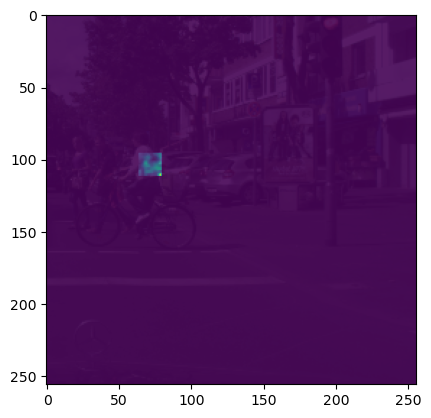

In [70]:
target_size = (256, 256)
rescaled_image_layer = cv2.resize(unnormalized_image, target_size)
print("rescaled image for plot ", rescaled_image_layer.shape)
print("Attention ", attention.shape)



# create a black image of target size
attention_map_layer = np.zeros(target_size)

print("attention pixel ", attention_pixel.shape)
upscaled_attention_factor = 2**(layer - 1)
print("upscaled attention factor ", upscaled_attention_factor)

upscaled_attention_pixel = cv2.resize(attention_pixel, (upscaled_attention_factor * patch_size, upscaled_attention_factor * patch_size))
print("upscaled attention pixel ", upscaled_attention_pixel.shape)
print("patch idx ", patch_idx)
print("patch size ", patch_size)
patch_start = ((patch_idx // int(np.sqrt(attention.shape[0])))*patch_size*upscaled_attention_factor, 
               (patch_idx % int(np.sqrt(attention.shape[0]))*patch_size*upscaled_attention_factor))
# patch_start = (patch_idx, patch_idx)
print("patch start ", patch_start)

attention_map_layer[patch_start[0]:patch_start[0] + upscaled_attention_pixel.shape[0], 
                    patch_start[1]:patch_start[1] + upscaled_attention_pixel.shape[1]] = upscaled_attention_pixel

# test = test + upscaled_attention_pixel
# print("test ", test.shape)

plt.imshow(rescaled_image_layer)
plt.imshow(attention_map_layer, alpha=0.9, cmap='viridis')
plt.show()


In [71]:
patch_idx = (pixel[1] // downsample_factor // patch_size) * (array_shape[1] // patch_size) + (pixel[0] // downsample_factor // patch_size)

print('Patch index = ', patch_idx)

Patch index =  100


In [72]:
# plt.imshow(attention_map_layer)
# plt.show()

In [73]:
# # Create an empty three-channel array
# atten_for_pixel_rgb = np.zeros((16, 16, 3))

# # Copy the single-channel data into each channel
# atten_for_pixel_rgb[:, :, 0] = attention_pixel
# # atten_for_pixel_rgb[:, :, 1] = atten_for_pixel
# # atten_for_pixel_rgb[:, :, 2] = atten_for_pixel

# # normalize by mean and std
# atten_for_pixel_rgb = (atten_for_pixel_rgb - np.mean(atten_for_pixel_rgb)) / np.std(atten_for_pixel_rgb)

# print('atten for pixel rgb', atten_for_pixel_rgb.shape)
# # plot the attention matrix
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Attention Matrix')
# ax.imshow(atten_for_pixel_rgb)
# plt.show()